                                                                             Yunlin Zhang (yz3142)
# Bayesian modeling
1. Generate fake data to model the process 
$$f(t)=\sum_{i=1}^m A_ie^{-\lambda_i t}$$
$$Y_i=f(t_i)+\sigma\xi_i$$
$$\frac{1}{\sigma}(Y_i-f(t_i))\sim\mathcal{N}(0,1)$$
We will pick a few set of fake data to see what the behavior is under different situations

2. The likelihood function is then
$$\begin{aligned}
\mathcal{L}((t,Y)_{i=1:\tau} |\ A,\lambda,\sigma)&\propto\prod_{i=1}^{N}\exp\bigg[-\frac{1}{2}\bigg(\frac{Y_i-f(t_i)}{\sigma}\bigg)^2\bigg]\\
&\propto\exp\bigg[-\frac{1}{2}\sum_{i=1}^{N}\bigg(\frac{Y_i-f(t_i)}{\sigma}\bigg)^2\bigg]
\end{aligned}$$

3. Implementation
To make it generic, we'll use classes and create object that inherit the interface for easier implementation. These are implemented in a separate file

Taking inspiration of ridge regression in a Bayesian setting, we'll set the priors as below:
$$
\begin{aligned}
p(A_i) &\propto \exp\left(-\sum A_i^2/2\right)\\
p(\lambda_i) &\propto \exp\left(-\sum \lambda_i^2/2\right)\\
p(\sigma) &\propto \exp\left(-\sigma^2/2\right)\\
\end{aligned}
$$
So we have the following simple likelihood for the data
$$\begin{aligned}
p((t,Y)_{i=1:\tau} |\ A,\lambda,\sigma)&\propto p(\sigma)\prod_{j=1}^M p(A_i)\prod_{j=1}^M p(\lambda_i)\mathcal{L}((t,Y)_{i=1:\tau} |\ A,\lambda,\sigma)\\
&\propto  \exp\left(-\sigma^2/2\right)\exp\left(-\sum A_i^2/2\right)\exp\left(-\sum \lambda_i^2/2\right)\prod_{i=1}^{N}\exp\bigg[-\frac{1}{2}\bigg(\frac{Y_i-f(t_i)}{\sigma}\bigg)^2\bigg]\\
&\propto \exp\left(-\sigma^2/2\right)\exp\left(-\sum A_i^2/2\right)\exp\left(-\sum \lambda_i^2/2\right) \exp\bigg[-\frac{1}{2}\sum_{i=1}^{N}\bigg(\frac{Y_i-f(t_i)}{\sigma}\bigg)^2\bigg]
\end{aligned}$$


In [21]:
import TfBayes as tb
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import seaborn as sns
import numpy.random as rn
%matplotlib inline

tb.DEBUG = False # disables some messages while running MCMC
rn.seed(0)

# First we run some tests with only 1 var

Even though we are running 1000 chains in parallel, we'll do analysis on the first chain to get the autocorrelation time since each independent chain should be the same. The hope is that the autocorrelation time is less than 5000 and we end up with 1000 samples from the parallel runs

In [22]:
n_chains = 1000 # run 1000 MCMC chain
n_var = 1 # model the sum with 1 component
n_samples = 5000 # take 10000 MCMC samples

# set initial state
s0 = [1.0/n_var * np.ones((n_chains, n_var)), np.ones((n_chains, n_var)), np.ones((n_chains, 1))]

### The fake data
The ground truth is created with $m=1$, $A=1$, $\lambda=1$, $\sigma=0.1$, the procedure is built into the class creation as the default, but we can visualize it below:


([<matplotlib.lines.Line2D at 0x22adb036d68>],
 <matplotlib.text.Text at 0x22adb019630>)

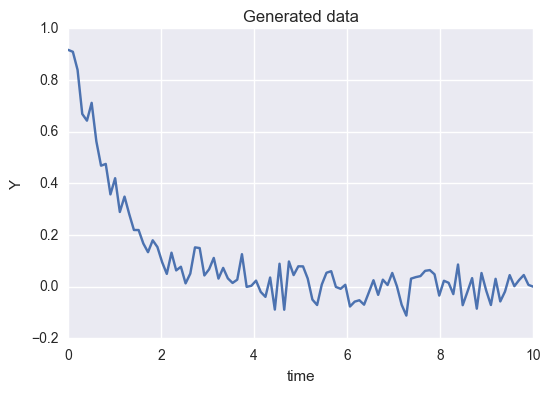

In [20]:
m = 1
A = np.asarray([1])
l = np.asarray([1])
sigma = 0.05

def generator(t):
    def _f(t): 
        return sum(np.multiply(A, np.exp(-1.0 * l * t))) + sigma * rn.normal()
    return np.vectorize(_f)(t) 

data = generator(np.linspace(0,10,100))
plt.plot(np.linspace(0,10,100), data), plt.xlabel('time'), plt.ylabel('Y'), plt.title('Generated data')

# Create a TfBayes object

In [25]:
tb1 = tb.TfBayes(s0, # initial state
              n_samples,  # number of samples
              n_chains=n_chains, # number of MCMC cchains
              size=n_var, # number of component
              tau=0.075, # the step size in Langevin dynamics
              data_gen=generator
             )

start = time.time()
tb1.mcmc_sample()
mcmc_chain_1 = tb1.mcmc_chain
accepted_cnt = tb1.accepted
del tb1
print('Done! {} seconds taken'.format(time.time() - start))

Done! 63.35490417480469 seconds taken


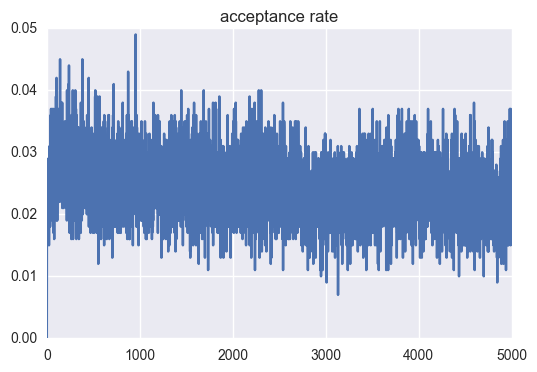

In [64]:
plt.plot(accepted_cnt[-1] / n_chains)
plt.title('acceptance rate')

The acceptance rate is approximately 30% in the long run

# Define the function below to analyze autocorrelation

In [56]:
def estimated_autocorrelation(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    # assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

def calculate_autocorrelation_time(autocorr, w=5):
    temp_val = autocorr * 2
    temp_val[0] -= 1 # reset the first element
    temp_val = np.cumsum(temp_val)
    for tau in range(len(autocorr)):
        if tau >= temp_val[w * tau]:
            return tau
    return -1

def do_autocorr_analysis(x, name):
    auto_x = estimated_autocorrelation(x)
    tau = calculate_autocorrelation_time(auto_x)
    plt.figure()
    plt.plot(auto_x[:min(2 * tau, len(x))]) # plot up to 2 * tau
    plt.title('Autocorrelation of {}. tau = {}'.format(name, tau))
    plt.xlabel('MCMC step')
    plt.ylabel('rho(t)')    

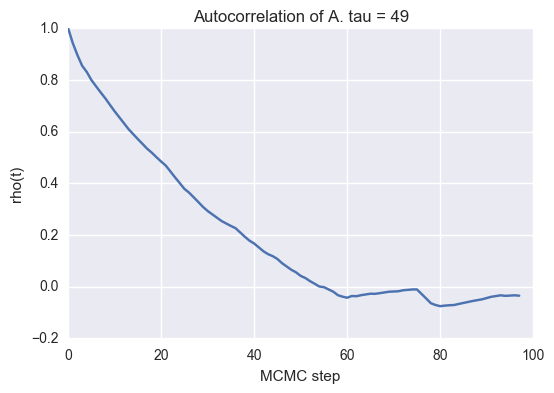

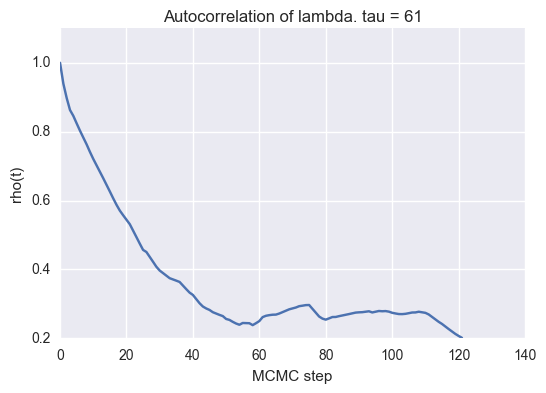

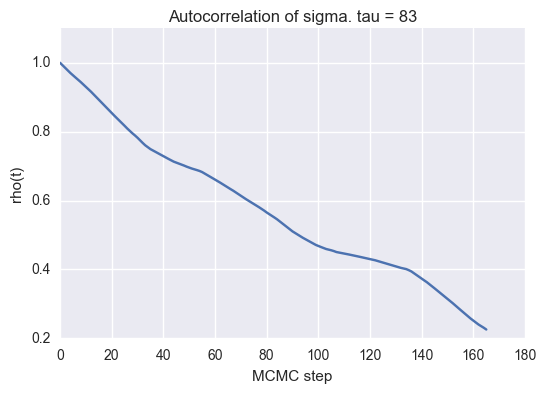

In [60]:
do_autocorr_analysis(mcmc_chain_1[-1][0][0,0,3000:], 'A')
do_autocorr_analysis(mcmc_chain_1[-1][1][0,0,3000:], 'lambda')
do_autocorr_analysis(mcmc_chain_1[-1][2][0,0,3000:], 'sigma')

The autocorrelation time for $\sigma$ is the highest, at 83, with the first 3000 samples used as burn-in. A few trials were done prior to presenting this result using 1000 and 2000 burn-in samples which resulted in much greater auto-correlation time, this seems to be a number than is reasonable and also reults in a good effective sample size. So effectively, with the 1000 parallel chains, we had a little more than 24,000 samples

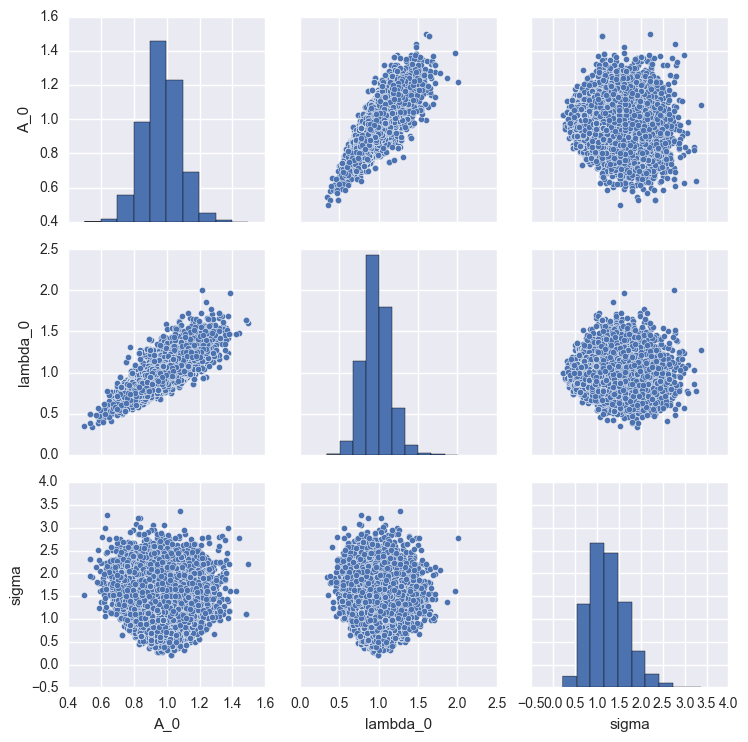

In [76]:
def make_pairwise_plots(data, burn, tau):
    import pandas as pd
    chains, components, samples = data[-1][0].shape
    A = data[-1][0][:,:,burn::tau]
    l = data[-1][1][:,:,burn::tau]
    s = data[-1][2][:,:,burn::tau]
    num_points = chains * (1 + int((samples - burn) / tau))
    df_values = np.zeros((num_points, 2 * components + 1))
    for i in range(components):
        df_values[:, i] = A[:, i, :].flatten()
        df_values[:, components + i] = l[:, i, :].flatten()
    df_values[:, -1] = s.flatten()
    df_headers = ['A_{}'.format(i) for i in range(components)]
    df_headers += ['lambda_{}'.format(i) for i in range(components)]
    df_headers += ['sigma']
    df = pd.DataFrame(data=df_values, columns=df_headers)
    sns.pairplot(df)
    
make_pairwise_plots(mcmc_chain_1, 3000, 83)

In this setup, we see that A and $\lambda$ can be correlated in the samples, and they have positive correlations. $\sigma$ seems to be overestimated

# Now what if we tried to fit sum of two exponentials, on the data that was generated with only 1

Done! 68.45354890823364 seconds taken


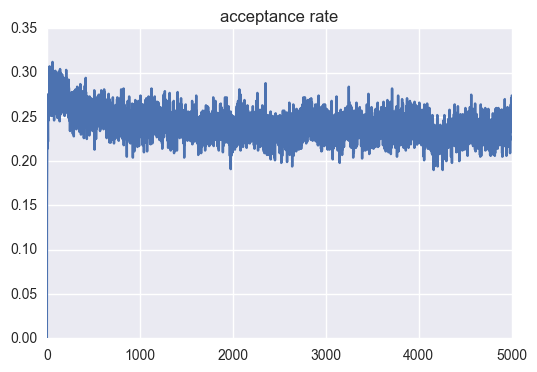

In [79]:
n_chains = 1000 # run 1000 MCMC chain
n_var = 2 # model the sum with 1 component
n_samples = 5000 # take 10000 MCMC samples

# set initial state
s0 = [1.0/n_var * np.ones((n_chains, n_var)), 
      np.ones((n_chains, n_var)), 
      np.ones((n_chains, 1))]

tb1 = tb.TfBayes(s0, # initial state
              n_samples,  # number of samples
              n_chains=n_chains, # number of MCMC cchains
              size=n_var, # number of component
              tau=0.008, # the step size in Langevin dynamics
              data_gen=generator
             )

start = time.time()
tb1.mcmc_sample()
mcmc_chain_1 = tb1.mcmc_chain
accepted_cnt = tb1.accepted
del tb1
print('Done! {} seconds taken'.format(time.time() - start))

plt.plot(accepted_cnt[-1] / n_chains)
plt.title('acceptance rate')

A_0 tau = 147
lambda_0 tau = 154
A_1 tau = 142
lambda_1 tau = 106
sigma tau = 107


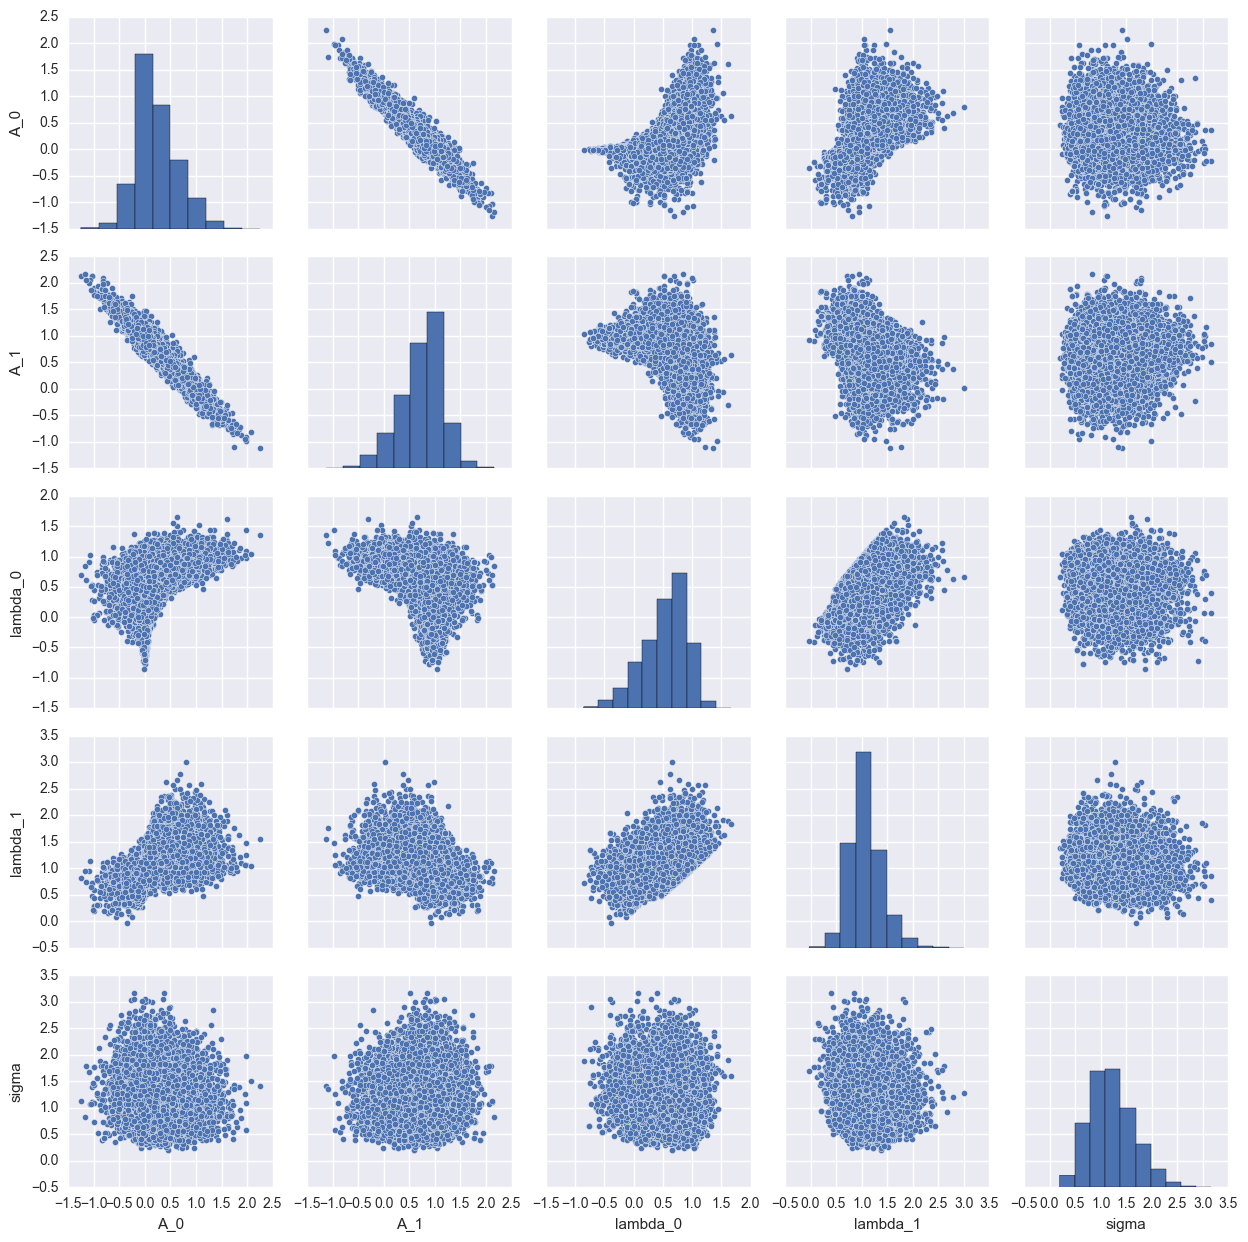

In [90]:
def analyze_results(data):  
    max_tau = 0
    for i in range(n_var):
        tau_a = calculate_autocorrelation_time(
                    estimated_autocorrelation(
                        data[-1][0][0,i,:]))
        max_tau = max(max_tau, tau_a)
        print('A_{} tau = {}'.format(i, tau_a))
        tau_l = calculate_autocorrelation_time(
                    estimated_autocorrelation(
                        data[-1][1][0,i,:]))
        max_tau = max(max_tau, tau_l)
        print('lambda_{} tau = {}'.format(i, tau_l))
    tau_s = calculate_autocorrelation_time(
                estimated_autocorrelation(
                    data[-1][2][0,0,:]))
    max_tau = max(max_tau, tau_s)
    print('sigma tau = {}'.format(tau_s))
    
    make_pairwise_plots(data, 3000, max_tau)
    
analyze_results(mcmc_chain_1)

Here we can observe that there is strong correlations between the two coefficient variable that add up to 1. This can be due to the fact that the first observation is independent of the two decay rate variables, and has a strong influence on the coefficients. In addition, we see interesting correlations and relationships between some other pairs of variables. The $\lambda$s are constrained to be in increasing order in the code, but there seems to be fairly strong modes for both of them. This could be that there is a component in the inferred sum that accounts for majority of the observations, while the second will pick up the residuals. $\sigma$ seems to be uncorrelated to any of the other parameter, which is good since we do not want the nuisance parameter to influence the samples.  $\sigma$ seems to be overestimated as well

# Now let's try 2 components in the ground truth, one with a long decay, and another with a short decay

([<matplotlib.lines.Line2D at 0x22ab881deb8>],
 <matplotlib.text.Text at 0x22ab87fe780>)

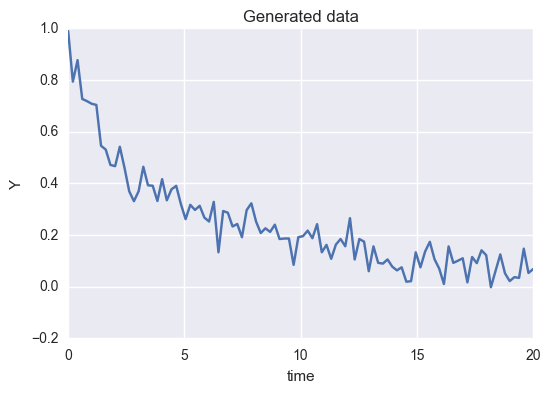

In [93]:
m = 2
A = np.asarray([0.5, 0.5])
l = np.asarray([0.1, 1])
sigma = 0.05

t = np.linspace(0, 20, 100)
data = generator(t)
plt.plot(t, data), plt.xlabel('time'), plt.ylabel('Y'), plt.title('Generated data')

# First what if we fit 1 component model

Done! 38.803850412368774 seconds taken


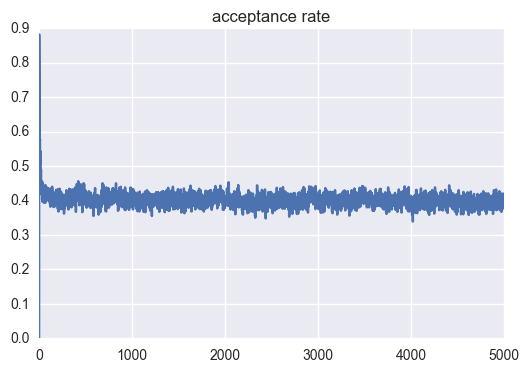

In [96]:
n_chains = 1000 # run 1000 MCMC chain
n_var = 1 # model the sum with 1 component
n_samples = 5000 # take 10000 MCMC samples

# set initial state
s0 = [1.0/n_var * np.ones((n_chains, n_var)), 
      np.ones((n_chains, n_var)), 
      np.ones((n_chains, 1))]

tb1 = tb.TfBayes(s0, # initial state
              n_samples,  # number of samples
              n_chains=n_chains, # number of MCMC cchains
              size=n_var, # number of component
              tau=0.05, # the step size in Langevin dynamics
              data_gen=generator,
              t=t # longer time to capture the longer decay model
             )

start = time.time()
tb1.mcmc_sample()
mcmc_chain_1 = tb1.mcmc_chain
accepted_cnt = tb1.accepted
del tb1
print('Done! {} seconds taken'.format(time.time() - start))

plt.plot(accepted_cnt[-1] / n_chains)
plt.title('acceptance rate')

A_0 tau = 12
lambda_0 tau = 14
sigma tau = 29


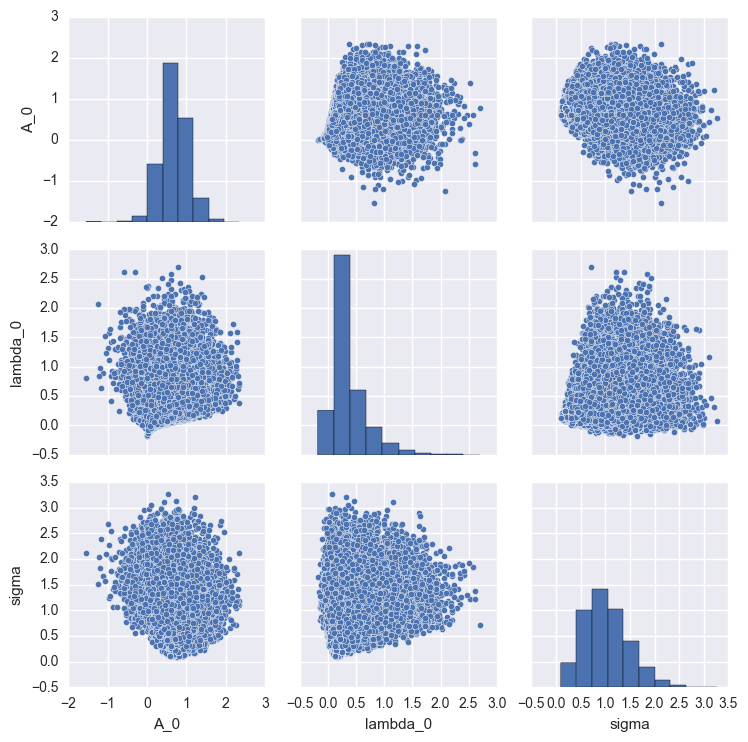

In [97]:
analyze_results(mcmc_chain_1)

There is no significant correlation between the parameters. It is not surprising that the mode for $\lambda$ is between that of the two components. Another thing of interest is that the autocorrelation time for this scheme is much shorter than what we've observed in the previous runs. 

# Now we try to fit 2 components

Done! 39.88297510147095 seconds taken


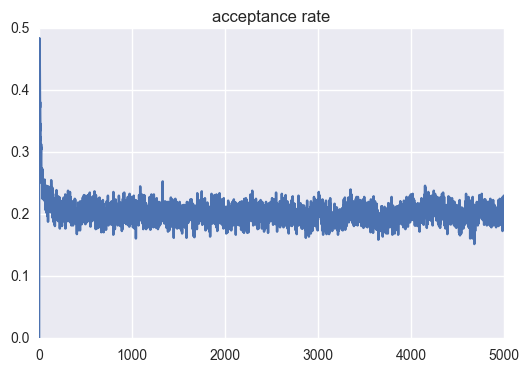

In [98]:
n_chains = 1000 # run 1000 MCMC chain
n_var = 2 # model the sum with 1 component
n_samples = 5000 # take 10000 MCMC samples

# set initial state
s0 = [1.0/n_var * np.ones((n_chains, n_var)), 
      np.ones((n_chains, n_var)), 
      np.ones((n_chains, 1))]

tb1 = tb.TfBayes(s0, # initial state
              n_samples,  # number of samples
              n_chains=n_chains, # number of MCMC cchains
              size=n_var, # number of component
              tau=0.05, # the step size in Langevin dynamics
              data_gen=generator,
              t=t # longer time to capture the longer decay model
             )

start = time.time()
tb1.mcmc_sample()
mcmc_chain_1 = tb1.mcmc_chain
accepted_cnt = tb1.accepted
del tb1
print('Done! {} seconds taken'.format(time.time() - start))

plt.plot(accepted_cnt[-1] / n_chains)
plt.title('acceptance rate')

A_0 tau = 74
lambda_0 tau = 43
A_1 tau = 68
lambda_1 tau = 112
sigma tau = 37


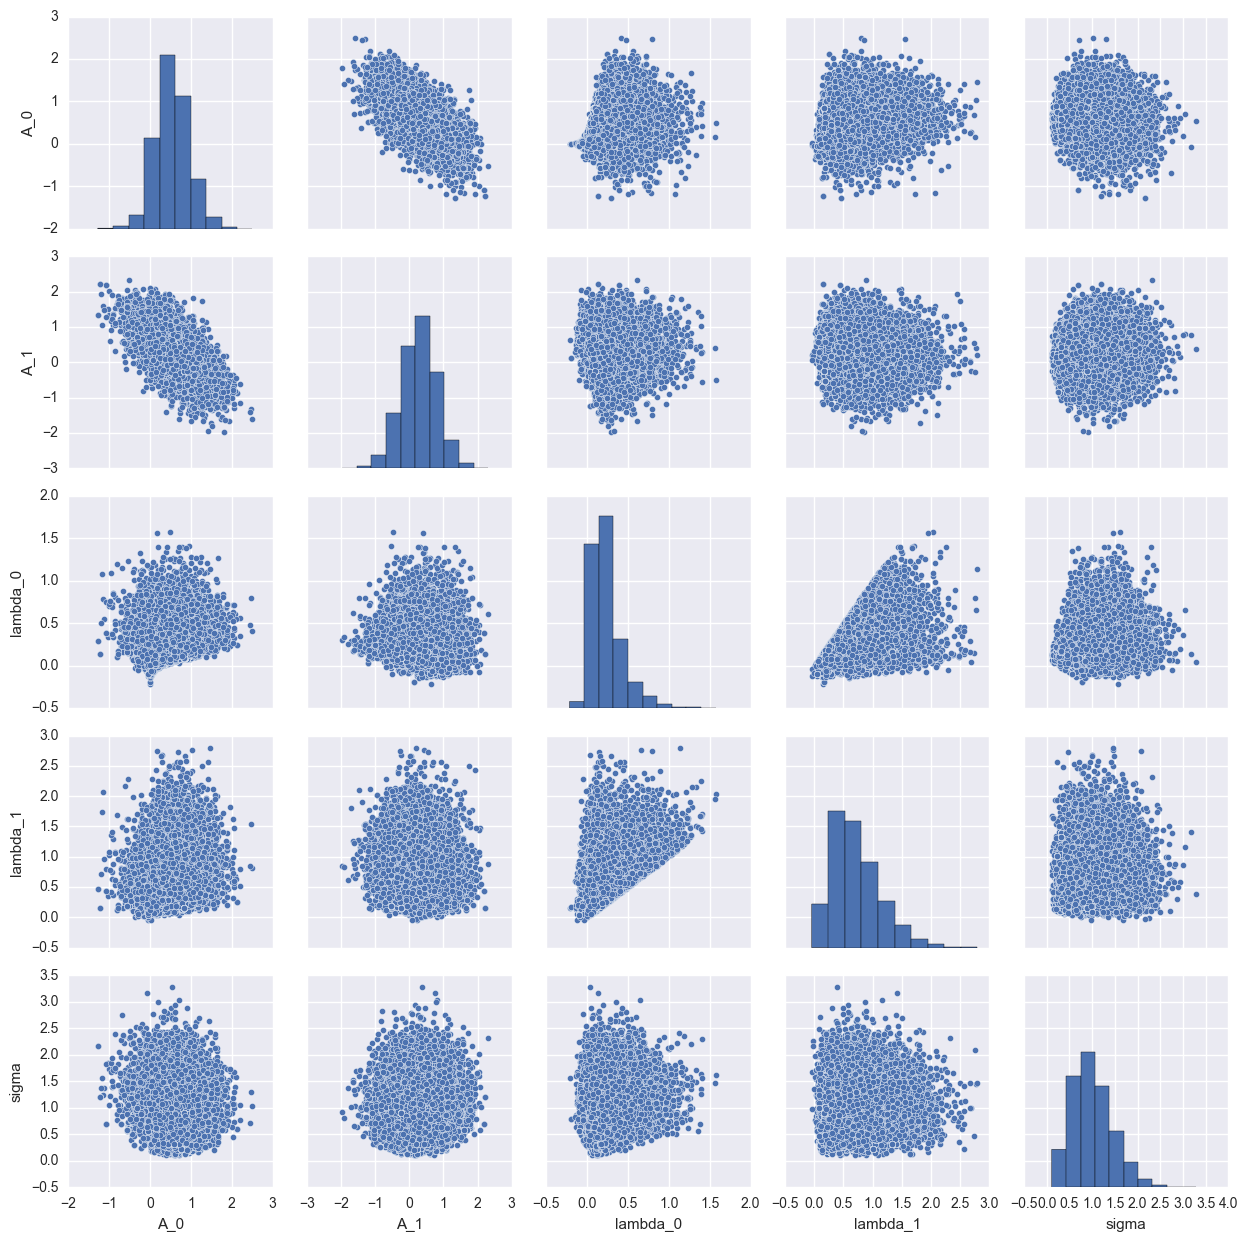

In [99]:
analyze_results(mcmc_chain_1)

The coefficients are still inversely correlated here as well, although this is weaker. The two $\lambda$s were able to pick up the two distinct decay rates in this case.

# Now let's try to fit 3 components to this data

Done! 44.5785698890686 seconds taken


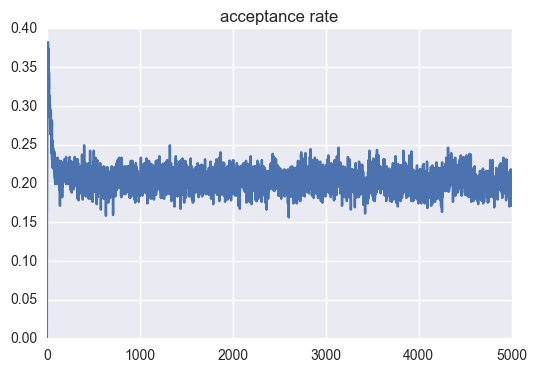

In [101]:
n_chains = 1000 # run 1000 MCMC chain
n_var = 3 # model the sum with 1 component
n_samples = 5000 # take 10000 MCMC samples

# set initial state
s0 = [1.0/n_var * np.ones((n_chains, n_var)), 
      np.ones((n_chains, n_var)), 
      np.ones((n_chains, 1))]

tb1 = tb.TfBayes(s0, # initial state
              n_samples,  # number of samples
              n_chains=n_chains, # number of MCMC cchains
              size=n_var, # number of component
              tau=0.025, # the step size in Langevin dynamics
              data_gen=generator,
              t=t # longer time to capture the longer decay model
             )

start = time.time()
tb1.mcmc_sample()
mcmc_chain_1 = tb1.mcmc_chain
accepted_cnt = tb1.accepted
del tb1
print('Done! {} seconds taken'.format(time.time() - start))

plt.plot(accepted_cnt[-1] / n_chains)
plt.title('acceptance rate')

A_0 tau = 206
lambda_0 tau = 26
A_1 tau = 131
lambda_1 tau = 60
A_2 tau = 214
lambda_2 tau = 76
sigma tau = 44


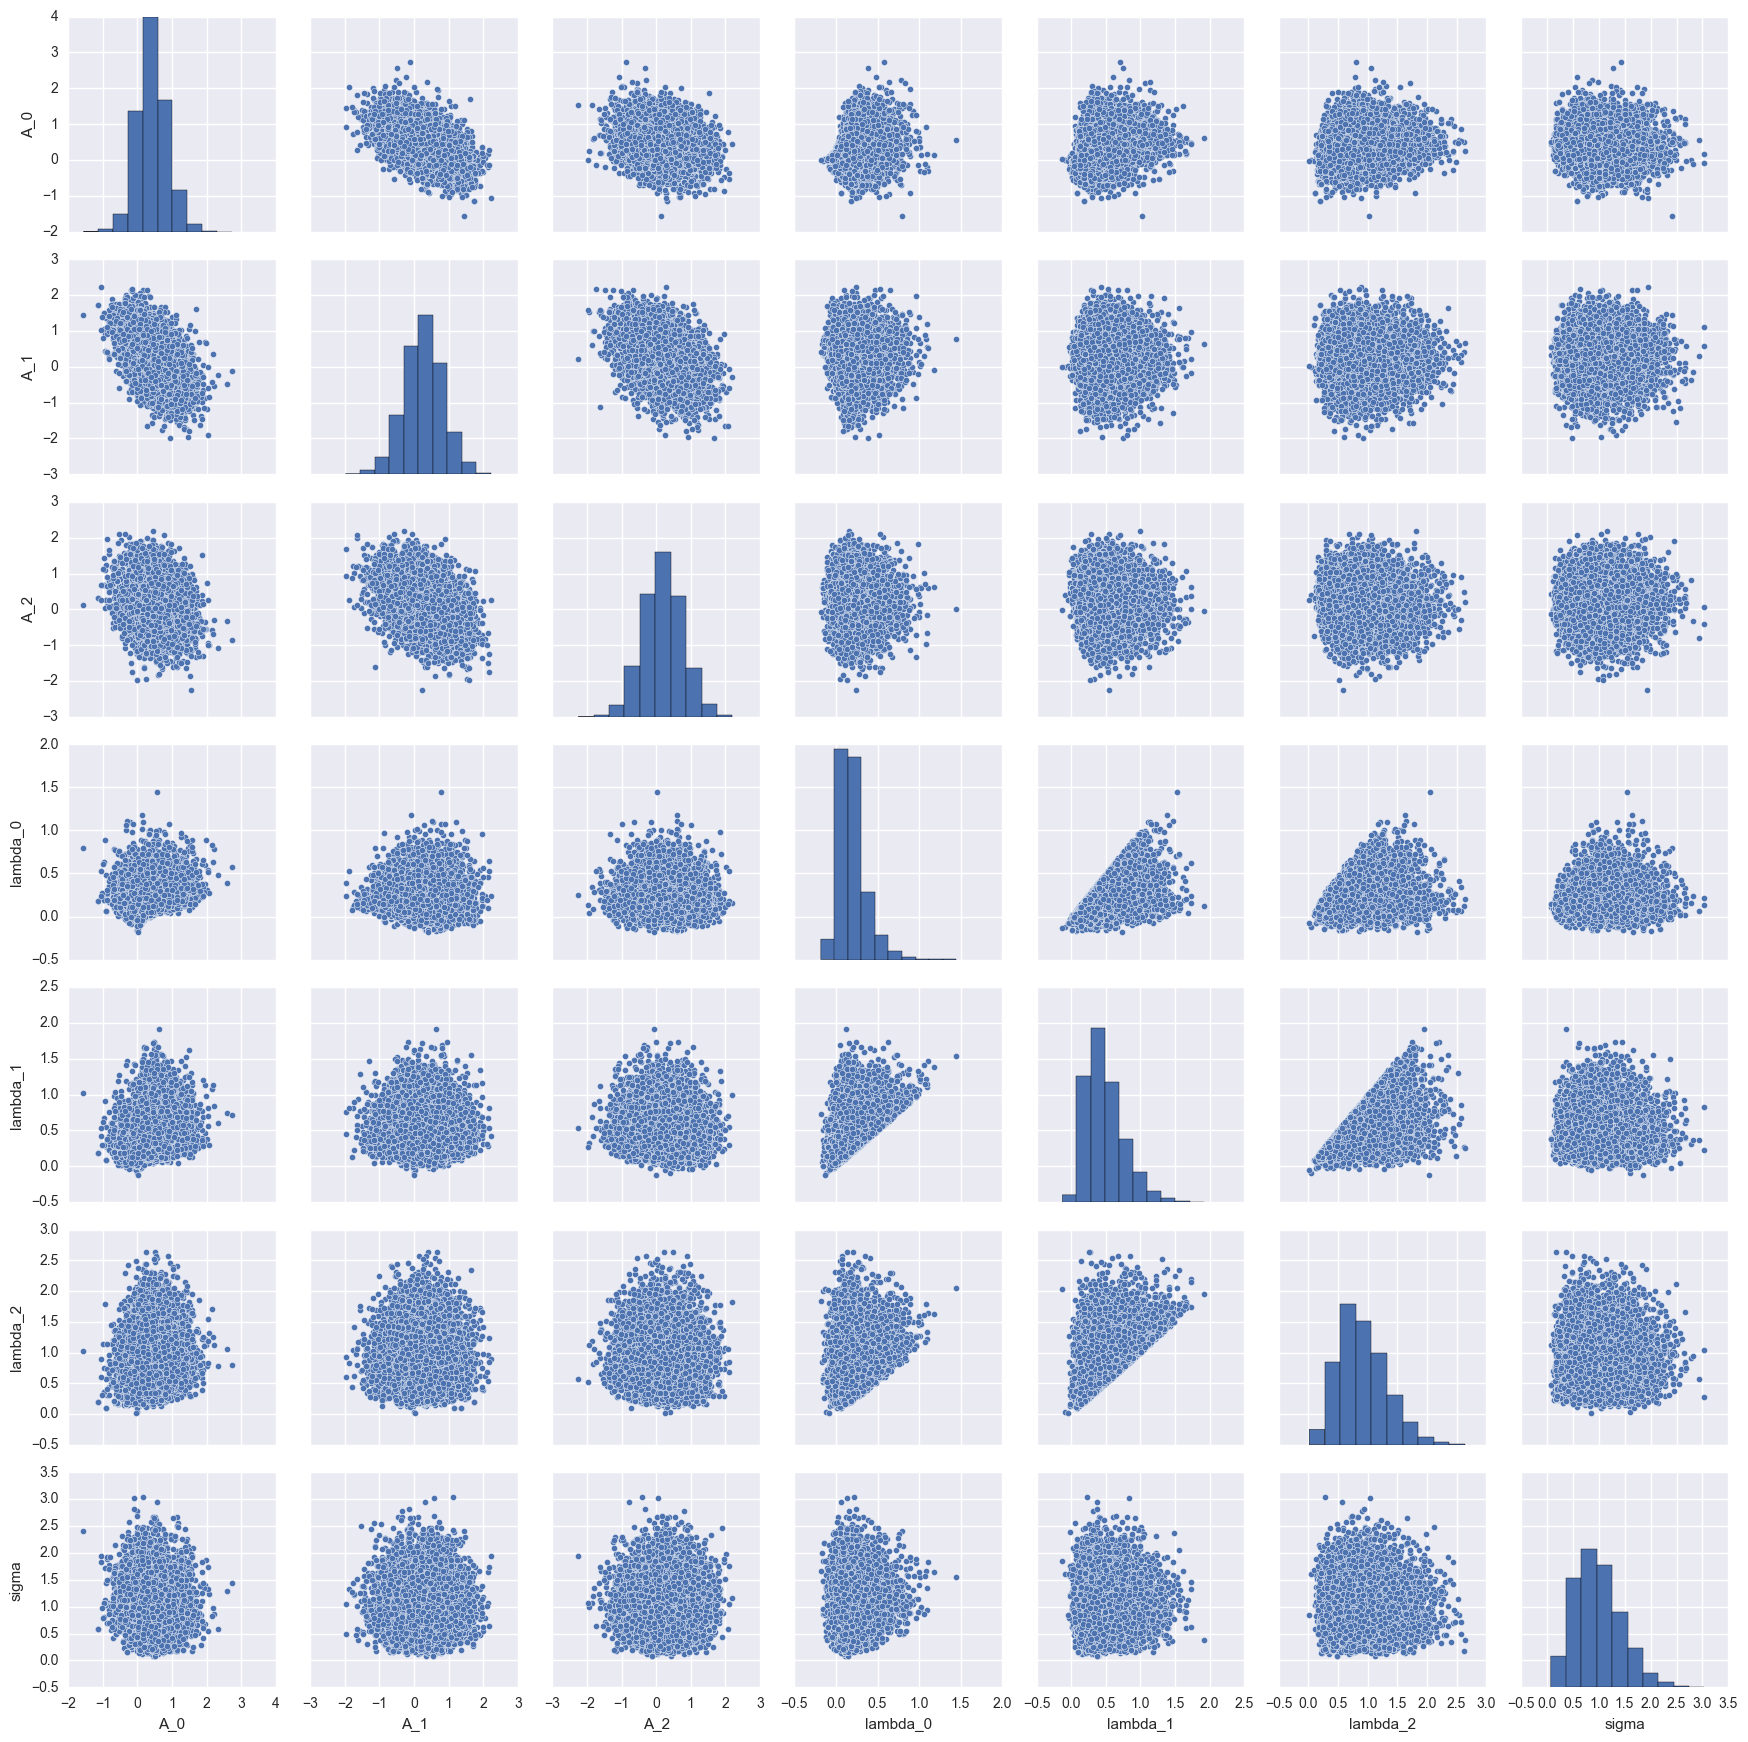

In [102]:
analyze_results(mcmc_chain_1)

The correlation between the coefficients seem to be weaker in this instance, and the additional decay component is right in the middle of the slow and fast rates, which can be a mechanism for picking up the noise residual.

# Observations and conclusions

We see that in general if ther are multiple components in the sum in the model, the coefficients tend to be inversely correlated. This can probably be explained by the fact that there is an upper limit on their sum coming from the first few terms in the data series. $\lambda$ estimates seem to be pretty accurate when the number of components is equal to or greater than the actual number of components used to generate the data. In all cases, it seems like $\sigma$ is overestimated. 

# Package design concept and code

The package is built on top of Tensorflow taking advantage of its auto-differentiation capabilities. Additionally, the package allows us to run the MCMC sampler on a GPU so we were able to run a large number of chains in parallel for a decent number of steps in relatively short period of time. 